# Expense Forecaster

The goal of this project is to develop a machine learning model that can accurately forecast total daily expenses based on historical transaction data. By analyzing past spending patterns, we aim to build a predictive tool that can anticipate future expenditures. This notebook documents the process from initial data exploration and cleaning to feature engineering, modeling, and evaluation.

## Setup

In [73]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

sns.set_style("whitegrid")
sns.set_palette("muted")
sns.set_context("notebook")

## Dataset

This project uses the "Personal Budget Transactions Dataset" dataset, which is publicly available on [Kaggle](https://www.kaggle.com/datasets/ismetsemedov/personal-budget-transactions-dataset). This dataset contains personal budget transaction records collected over a period of ~3 years.

In [4]:
df = pd.read_csv('expenses_data.csv')

In [5]:
df.shape

(4597, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4597 entries, 0 to 4596
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      4597 non-null   object 
 1   category  4597 non-null   object 
 2   amount    4597 non-null   float64
dtypes: float64(1), object(2)
memory usage: 107.9+ KB


In [7]:
df.isnull().sum()

date        0
category    0
amount      0
dtype: int64

No null values, which makes it easier for us.

## Preprocessing

In [8]:
df

,date,category,amount
0,2022-07-06 05:57:10 +0000,Restuarant,5.50
1,2022-07-06 05:57:27 +0000,Market,2.00
2,2022-07-06 05:58:12 +0000,Coffe,30.10
3,2022-07-06 05:58:25 +0000,Market,17.33
4,2022-07-06 05:59:00 +0000,Restuarant,5.50
...,...,...,...
4592,2025-03-09 18:16:33 +0000,Market,2.88
4593,2025-03-10 02:50:47 +0000,Transport,0.50
4594,2025-03-10 13:25:19 +0000,Transport,0.50
4595,2025-03-10 14:21:57 +0000,Market,7.50


As we can see, the date is in a timestamp format, from which we will extract each individual component for better understanding.
We will also use the OneHotEncoder() function to convert the categories into a numerical format that can be understood by our models.

In [9]:
df['category'].unique()

array(['Restuarant', 'Market', 'Coffe', 'Transport', 'Other', 'Phone',
       'Communal', 'Clothing', 'Motel', 'Travel', 'Rent Car', 'Sport',
       'Events', 'Learning', 'Health', 'Taxi', 'Business lunch',
       'Film/enjoyment', 'Tech', 'joy', 'Fuel', 'business_expenses'],
      dtype=object)

We can also see variations in the naming of categories, such as 'joy', and 'business_expenses'. We will fix them for better consistency.

Let us now create a new dataframe to contain all the processed numerical data.

In [10]:
df["date"] = pd.to_datetime(df["date"]) # To convert the column from object type to datetime type

category_replacements = {
    'Restuarant': 'Restaurant',
    'Coffe': 'Coffee',
    'joy': 'Joy',
    'business_expenses': 'Business Expenses'
}

df['category'] = df['category'].replace(category_replacements)

In [11]:
df_date = pd.DataFrame({
    "year": df["date"].dt.year,
    "month": df["date"].dt.month,
    "day": df["date"].dt.day,
    "hour": df["date"].dt.hour,
    "minute": df["date"].dt.minute,
    "weekday": df["date"].dt.weekday
})

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

encoded_values = encoder.fit_transform(df[['category']])
new_cols = encoder.get_feature_names_out(['category'])

df_encoded = pd.DataFrame(encoded_values, columns=new_cols, index=df.index)

df_numeric = pd.concat([df_date, df_encoded, df.drop(columns=['date','category',])], axis=1)

In [12]:
df_numeric

,year,month,day,hour,minute,weekday,category_Business Expenses,category_Business lunch,category_Clothing,category_Coffee,category_Communal,category_Events,category_Film/enjoyment,category_Fuel,category_Health,category_Joy,category_Learning,category_Market,category_Motel,category_Other,category_Phone,category_Rent Car,category_Restaurant,category_Sport,category_Taxi,category_Tech,category_Transport,category_Travel,amount
0,2022,7,6,5,57,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.50
1,2022,7,6,5,57,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.00
2,2022,7,6,5,58,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.10
3,2022,7,6,5,58,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.33
4,2022,7,6,5,59,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4592,2025,3,9,18,16,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.88
4593,2025,3,10,2,50,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.50
4594,2025,3,10,13,25,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.50
4595,2025,3,10,14,21,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.50


We can now start analyzing the data!

## Exploratory Data Analysis (EDA)

First let's plot total spending over time, then check category-wise spending trends.

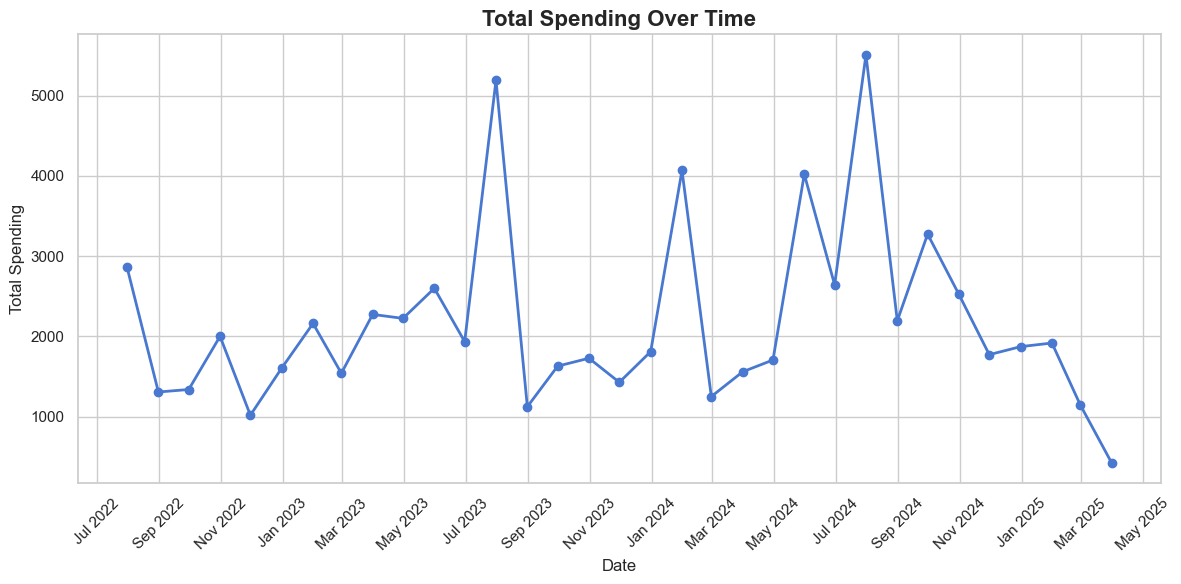

In [13]:
# Plot 1: Total spending over time
# We aggregate spending by month for cleaner trend
monthly_spending = df.groupby(pd.Grouper(key='date', freq='ME'))['amount'].sum()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(monthly_spending, marker='o', linestyle='-', linewidth=2)
ax.set_title('Total Spending Over Time', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Spending', fontsize=12)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Insights:
- Monthly spending shows a lot of fluctuation, which makes it hard to predict future per-day spending.
- Some months, July in particular, have significantly higher expenses, possibly due to seasonal factors. 

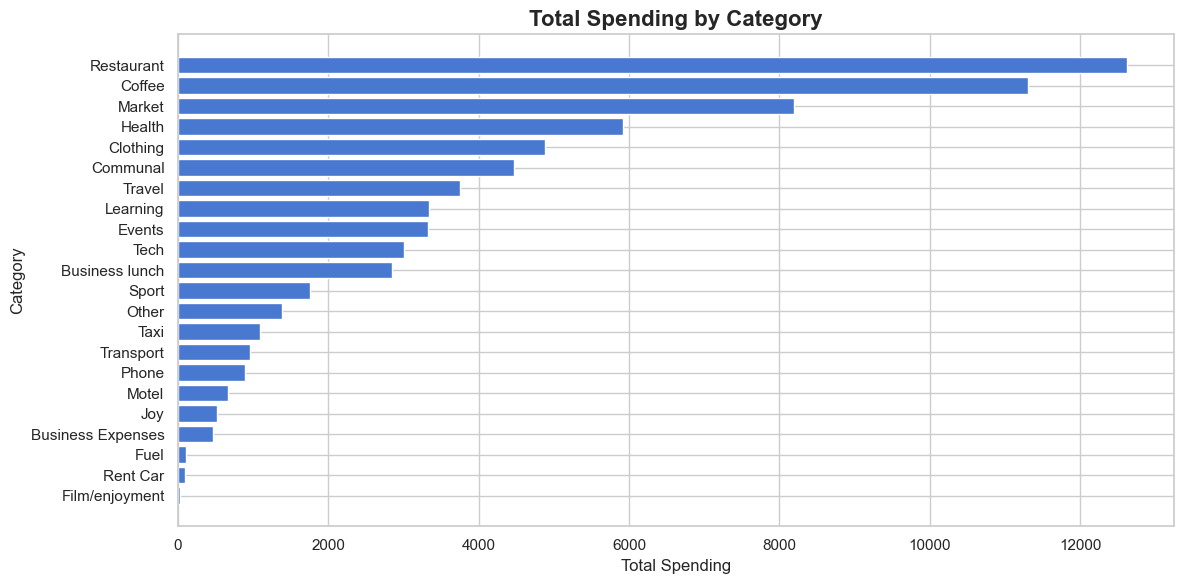

In [14]:
# Plot 2: Category-wise spending
category_columns = [col for col in df_numeric.columns if col.startswith('category_')]
category_spending = {}

for col in category_columns:
    category_name = col.replace('category_', '')
    total_spent = df_numeric[df_numeric[col] == 1]['amount'].sum()
    category_spending[category_name] = total_spent

# Sort the categories by spending
sorted_category_spending = sorted(category_spending.items(), key=lambda item: item[1], reverse=True)
sorted_categories = [item[0] for item in sorted_category_spending]
sorted_spending = [item[1] for item in sorted_category_spending]

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(sorted_categories, sorted_spending)
ax.set_title('Total Spending by Category', fontsize=16, fontweight='bold')
ax.set_xlabel('Total Spending', fontsize=12)
ax.set_ylabel('Category', fontsize=12)
ax.invert_yaxis()  # To display the highest spending at the top
plt.tight_layout()
plt.show()

#### Insights:
- Spending is unevenly distributed across categories.
- Categories Restaurant and Coffee dominate most expenses, followed by Market and Health.
- The graph shows a classic "long tail" pattern. This means we have a few categories with very high spending and a large number of categories with much lower spending, which might make it harder for the model to predict the lower spending categories.

Now that we've analyzed the data, we can move on training our models.

## Regression Modeling for Forecasting

Our goal is to predict future expenditure. To do so we will first start with a simple Ridge Regression and compare performance     with Random Forests.



In [74]:
df_numeric = df_numeric.sort_values(by=['year', 'month', 'day', 'hour', 'minute'])

X = df_numeric.drop('amount', axis=1)
y = df_numeric['amount'].values.reshape(-1, 1) # Use reshape for scaler

# 3. Perform a clean, time-based split (80% train, 20% test)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# Model 1: Ridge Regression
print("--- Ridge Regression ---")
ridge = Ridge(alpha=10)
ridge.fit(X_train_scaled, y_train_scaled.ravel()) # .ravel() to make y 1D
ridge_score = ridge.score(X_test_scaled, y_test_scaled.ravel())
print(f"Ridge R² Score on Test Set: {ridge_score:.4f}")


# Model 2: Random Forest Regressor
print("\n--- Random Forest Regressor ---")
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

# .ravel() converts the y shape from (n, 1) to (n,), which the model expects
rf.fit(X_train_scaled, y_train_scaled.ravel())
rf_score = rf.score(X_test_scaled, y_test_scaled.ravel())
print(f"Random Forest R² Score on Test Set: {rf_score:.4f}")

--- Ridge Regression ---
Ridge R² Score on Test Set: -0.5155

--- Random Forest Regressor ---
Random Forest R² Score on Test Set: -0.9880


In [75]:
# --- REVISED APPROACH: FORECASTING DAILY TOTALS ---

# Make sure the original dataframe's date is a datetime object and it's sorted
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)

# 1. Resample the data to get the total amount spent per day
df_daily = df.resample('D', on='date')['amount'].sum().reset_index()

# 2. Create Time-Series Features (Lag and Rolling Window)
# These are powerful features for forecasting
df_daily['amount_lag_1'] = df_daily['amount'].shift(1)  # Previous day's total
df_daily['amount_lag_7'] = df_daily['amount'].shift(7)  # Total from a week ago
df_daily['rolling_mean_7'] = df_daily['amount'].shift(1).rolling(window=7).mean() # Avg of last 7 days

# 3. Create Date-based Features
df_daily['dayofweek'] = df_daily['date'].dt.dayofweek
df_daily['month'] = df_daily['date'].dt.month
df_daily['year'] = df_daily['date'].dt.year

# 4. Prepare Data for Modeling
#    - Drop the original date column as we've extracted its info
#    - Drop rows with NaN values (created by our shift/rolling features)
df_final = df_daily.drop('date', axis=1).dropna()

X = df_final.drop('amount', axis=1)
y = df_final['amount']

# 5. Perform a time-based split on the new daily data
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# 6. Train the Random Forest Model (Scaling is less critical for RF)
print("--- Training Random Forest on Daily Totals ---")
rf_daily = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_daily.fit(X_train, y_train)
rf_daily_score = rf_daily.score(X_test, y_test)

print(f"\nRandom Forest R² Score on Daily Totals: {rf_daily_score:.4f}")

--- Training Random Forest on Daily Totals ---

Random Forest R² Score on Daily Totals: -0.1143


In [76]:
# --- FINAL APPROACH: AGGREGATION + LOG TRANSFORMATION ---

# (We assume df_daily and feature creation steps from the previous response are done)

# 1. Prepare Data for Modeling (using the df_daily from before)
df_final = df_daily.drop('date', axis=1).dropna()

X = df_final.drop('amount', axis=1)
# Apply log transformation to the target variable
y = np.log1p(df_final['amount']) 

# 2. Perform a time-based split
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# 3. Train the Random Forest Model on the log-transformed y
print("--- Training Random Forest on Log-Transformed Daily Totals ---")
rf_log = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_log.fit(X_train, y_train)

# 4. Make predictions and reverse the transformation
y_pred_log = rf_log.predict(X_test)
y_pred_actual = np.expm1(y_pred_log) # Reverse the log1p transformation

# We need to compare with the original, non-log-transformed y_test
y_test_actual = np.expm1(y_test)

# 5. Evaluate the score on the ACTUAL values
from sklearn.metrics import r2_score
final_score = r2_score(y_test_actual, y_pred_actual)

print(f"\nRandom Forest R² Score on Daily Totals (after Log Transform): {final_score:.4f}")

--- Training Random Forest on Log-Transformed Daily Totals ---

Random Forest R² Score on Daily Totals (after Log Transform): -0.0800


In [77]:
# --- FINAL APPROACH: PIVOTING CATEGORIES FOR CONTEXT ---

# Start with the original dataframe, ensure date is datetime and sorted
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)

# 1. Create a pure date column for grouping
df['date_only'] = df['date'].dt.date

# 2. Pivot the data to get daily spending PER category
# This creates our new context features
df_pivot = pd.pivot_table(df, values='amount', index='date_only', columns='category', aggfunc='sum', fill_value=0)

# 3. Resample to get the daily TOTAL amount (our target variable 'y')
df_daily_target = df.resample('D', on='date')['amount'].sum().reset_index()
df_daily_target['date_only'] = df_daily_target['date'].dt.date

# 4. Merge the features and the target together
df_final = pd.merge(df_daily_target[['date_only', 'amount']], df_pivot, on='date_only', how='left').fillna(0)

# 5. Create Time-Series Features (Lag and Rolling Window on the TOTAL amount)
df_final['total_amount_lag_1'] = df_final['amount'].shift(1)
df_final['rolling_mean_7'] = df_final['amount'].shift(1).rolling(window=7).mean()

# Add date features
df_final['dayofweek'] = pd.to_datetime(df_final['date_only']).dt.dayofweek
df_final['month'] = pd.to_datetime(df_final['date_only']).dt.month

# 6. Prepare Data for Modeling
df_final = df_final.drop('date_only', axis=1).dropna()

X = df_final.drop('amount', axis=1)
y = df_final['amount']

# 7. Perform the final time-based split
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# 8. Train and Evaluate the Random Forest Model
print("--- Training RF with Daily Category Features ---")
rf_final = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_final.fit(X_train, y_train)
final_score = rf_final.score(X_test, y_test)

print(f"\nRandom Forest R² Score with Category Features: {final_score:.4f}")

--- Training RF with Daily Category Features ---

Random Forest R² Score with Category Features: 0.5992


[]

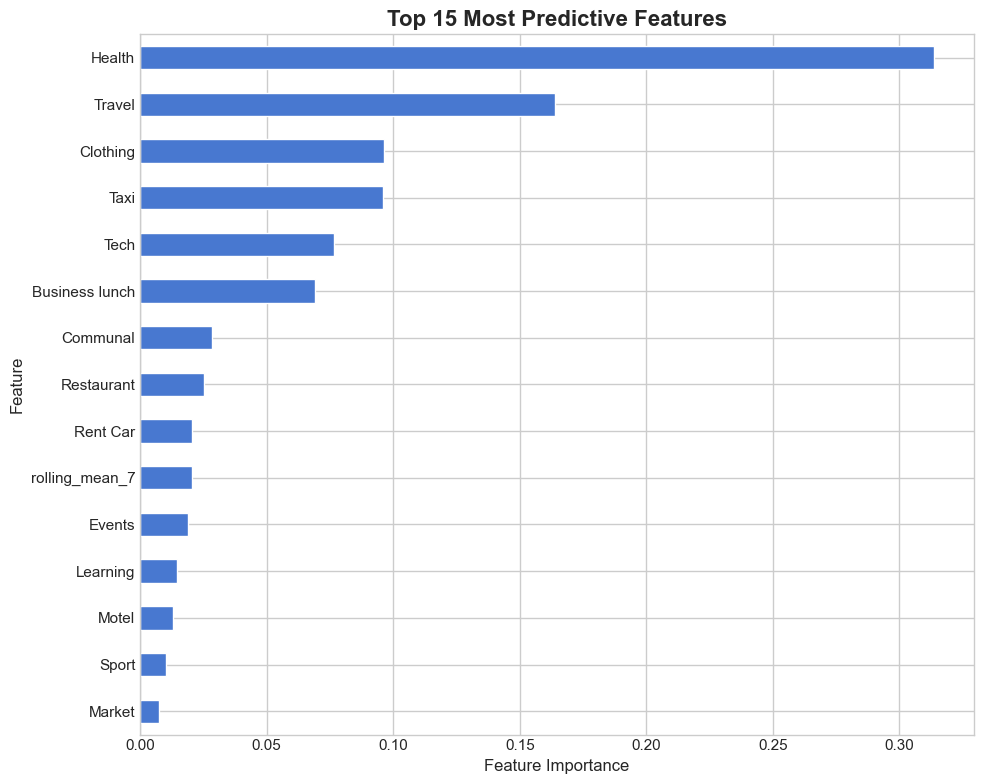

In [ ]:
# --- Feature Importance Visualization ---

# Create a series with feature names and their importance scores
feature_importances = pd.Series(rf_final.feature_importances_, index=X_train.columns)

# Get the top 15 most important features
top_features = feature_importances.nlargest(15)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 8))
top_features.sort_values().plot(kind='barh', ax=ax)

ax.set_title('Top 15 Most Predictive Features', fontsize=16, fontweight='bold')
ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.plot()